In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os


In [2]:
class FaceFolderDataset(Dataset):
    def __init__(self, root_dir, images_limit=16, dirs=None):
        self.images_limit = images_limit
        self.root_dir = root_dir
        self.persons = sorted(os.listdir(root_dir))
        if dirs is not None:
            for p in self.persons:
                if p not in dirs:
                    self.persons.remove(p)
        self.person_to_idx = {person: index for index, person in enumerate(self.persons)}
        self.person_indexes = []
        self.image_paths = []

        for i, c in enumerate(self.persons):
            pearson_dir = os.path.join(self.root_dir, c)
            for file_name in os.listdir(pearson_dir):
                if file_name not in [f"{idx}.png" for idx in range(images_limit)]:
                    continue
                self.image_paths.append(os.path.join(pearson_dir, file_name))


    def __getitem__(self, index: int)-> list[torch.Tensor]:
        person = self.persons[index]
        person_dir = os.path.join(self.root_dir, person)
        person_image_paths = os.listdir(person_dir)
        result_images = []
        for image_path in person_image_paths:
            if not image_path.endswith(".png"):
                warnings.warn(f"Image {image_path} is not a png file")
                continue
            image = Image.open(os.path.join(person_dir, image_path))
            image = image.convert("RGB")
            image = transforms.ToTensor()(image)
            image = image / 255
            if image.shape != (3, 112, 112):
                raise ValueError(f"Image {image_path} has shape {image.shape} instead of (3, 112, 112)")
            result_images.append(image)
        return result_images


    def get_person_images(self, person, limit=None):
        if (limit is not None) and (limit > self.images_limit):
            warnings.warn(f"Limit {limit} is greater than images limit {self.images_limit} (numbers of photos im one folder)")
        person_dir = os.path.join(self.root_dir, person)
        person_image_paths = os.listdir(person_dir)
        np.random.shuffle(person_image_paths)
        result_images = []
        for image_path in person_image_paths:
            if not image_path.endswith(".png"):
                warnings.warn(f"Image {image_path} is not a png file")
                continue
            image = Image.open(os.path.join(person_dir, image_path))
            image = image.convert("RGB")
            image = transforms.ToTensor()(image)
            image = image / 255
            if image.shape != (3, 112, 112):
                raise ValueError(f"Image {image_path} has shape {image.shape} instead of (3, 112, 112)")
            result_images.append(image)
            if limit is not None and len(result_images) >= limit:
                break
        return result_images


    def __len__(self):
        return len(self.persons)

In [3]:
import itertools


class FaceDataLoader:
    def __init__(self, face_dataset: FaceFolderDataset, shuffle=False, num_workers=0):
        batch_size = face_dataset.images_limit
        self.dataset: FaceFolderDataset = face_dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.num_workers = num_workers


    def __iter__(self)-> torch.Tensor:
        if self.shuffle:
            persons = np.random.permutation(self.dataset.persons)
        else:
            persons = self.dataset.persons
        for i, person in enumerate(persons):
            images = self.dataset[self.dataset.person_to_idx[person]]
            yield torch.stack(images), person

    def iter_same_person_batch(self, batch_size: int)-> torch.Tensor:
        persons = self.dataset.persons
        random.shuffle(persons)
        for person in persons:
            images = self.dataset.get_person_images(person, limit=batch_size)
            yield torch.stack(images)

    def iter_different_person_batch(self, batch_size: int)-> torch.Tensor:
        # iter for person in all avalibale batch_size length persons combinations
        for persons in itertools.combinations(self.dataset.persons, batch_size):
            images = []
            for person in persons:
                images.append(random.choice(self.dataset.get_person_images(person, limit=1)))
            yield torch.stack(images)

    def __len__(self):
        return len(self.dataset) // self.batch_size

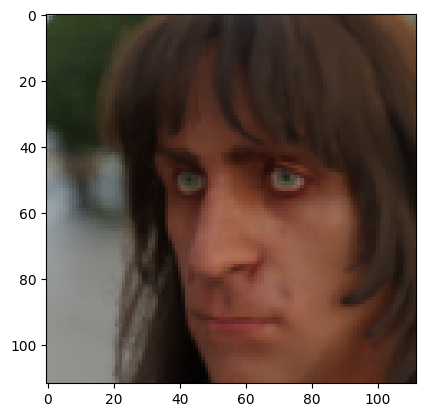

In [4]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Создаем датасет
 # TODO something wrong with images limits
test_dataset = FaceFolderDataset('images', images_limit=72, dirs=[str(i) for i in range(12)])
train_dataset = FaceFolderDataset('images', images_limit=72, dirs=[str(i) for i in range(12, 4000)])
# Создаем загрузчик данных
dataloader = FaceDataLoader(train_dataset, shuffle=True)
test_dataloader = FaceDataLoader(test_dataset, shuffle=True)
# Получаем один пакет данных из загрузчика
images, labels = next(iter(dataloader))

image = images[0]
label = labels[0]
plt.imshow(255 * image.permute(1, 2, 0).numpy())
plt.show()

In [5]:
import warnings

model = nn.Sequential( # Input image size = 112 x 112
    nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2), # Output image size = 56 x 56
    nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2), # Output image size = 28 x 28
    nn.Conv2d(in_channels=32, out_channels=48, kernel_size=3, padding=1),
    nn.BatchNorm2d(48),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(48 * 28 * 28, 4096),
    nn.ReLU(),
    nn.Linear(4096, 128),
    nn.ReLU()
)
device = torch.device('cuda')
model = model.to(device)


In [6]:
# Use torchsummary to check model memory usage
import torchsummary as ts
ts.summary(model, (3, 112, 112), batch_size=72, device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [72, 32, 112, 112]             896
       BatchNorm2d-2         [72, 32, 112, 112]              64
              ReLU-3         [72, 32, 112, 112]               0
         MaxPool2d-4           [72, 32, 56, 56]               0
            Conv2d-5           [72, 32, 56, 56]           9,248
       BatchNorm2d-6           [72, 32, 56, 56]              64
              ReLU-7           [72, 32, 56, 56]               0
         MaxPool2d-8           [72, 32, 28, 28]               0
            Conv2d-9           [72, 48, 28, 28]          13,872
      BatchNorm2d-10           [72, 48, 28, 28]              96
             ReLU-11           [72, 48, 28, 28]               0
          Flatten-12                [72, 37632]               0
           Linear-13                 [72, 4096]     154,144,768
             ReLU-14                 [7

In [7]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [8]:
import random
# Loss function calculate difference between n vectors (torch tensors)
def difference_loss(y: torch.Tensor)-> torch.Tensor:
    """Returns mean distance between all vectors in y"""
    return torch.cdist(y, y).mean()

def similarity_loss(y: torch.Tensor)-> torch.Tensor:
    return -difference_loss(y)



In [10]:
from tqdm.notebook import tqdm

losses = []
different_losses = []
same_losses = []

test_losses = []
test_different_losses = []
test_same_losses = []

for epoch in tqdm(range(1)):
    for same_images, different_images in tqdm(zip(dataloader.iter_same_person_batch(64), dataloader.iter_different_person_batch(64)), total=3999):
        optimizer.zero_grad()
        same_images = same_images.to(device)
        different_images = different_images.to(device)
        same_embeddings = model(same_images)
        different_embeddings = model(different_images)

        dif_loss = difference_loss(same_embeddings)
        sim_loss = similarity_loss(different_embeddings)
        different_losses.append(dif_loss.item())
        same_losses.append(sim_loss.item())
        loss = dif_loss + sim_loss
        loss.backward()
        optimizer.step()
        losses.append(loss.item())


        with torch.no_grad():
            test_same_images, test_different_images = next(iter(test_dataloader.iter_same_person_batch(64))), next(iter(test_dataloader.iter_different_person_batch(64)))
            test_same_images = test_same_images.to(device)
            test_different_images = test_different_images.to(device)

            test_same_embeddings = model(test_same_images)
            test_different_embeddings = model(test_different_images)

            test_sim_loss = similarity_loss(test_different_embeddings)
            test_dif_loss = difference_loss(test_same_embeddings)

            test_different_losses.append(test_dif_loss.item())
            test_same_losses.append(test_sim_loss.item())
            test_losses.append((test_sim_loss + test_dif_loss).item())






  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3999 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# plot different losses, same losses and total loss in one plot
plt.plot(losses, label='total loss')
plt.plot(different_losses, label='different loss')
plt.plot(same_losses, label='same loss')
plt.legend()
plt.show()

In [ ]:
# plot different losses, same losses and total loss in one plot
plt.plot(test, label='total loss')
plt.plot(different_losses, label='different loss')
plt.plot(same_losses, label='same loss')
plt.legend()
plt.show()